In [1]:
# Dependencies
import requests
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pprint
from sklearn.cluster import DBSCAN


## 2023

In [2]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR=2023',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
all_data_2023 = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    all_data_2023.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [3]:
# Extract the 'DIVISION' values and create a DataFrame with all features
divisions = []
all_features = []

# Loop through each feature to extract the 'DIVISION' value and the entire feature
for feature in all_data_2023:
    division = feature['properties']['DIVISION']
    divisions.append(division)
    all_features.append(feature['properties'])  # Store the entire 'properties' for each feature

# Create a pandas DataFrame with the 'DIVISION' values and other properties
df = pd.DataFrame(all_features)

# Group the DataFrame by 'DIVISION' and display the corresponding features
grouped_by_division = df.groupby('DIVISION')

# Loop through each division and display its corresponding data
for division, group in grouped_by_division:
    print(f"\nDIVISION: {division}")
    print(group)  # Displays the rows corresponding to that division



DIVISION: D11
       OBJECTID EVENT_UNIQUE_ID    REPORT_DATE       OCC_DATE  REPORT_YEAR  \
28       323607     GO-20234114  1672549200000  1672549200000         2023   
49       323633     GO-20232270  1672549200000  1672549200000         2023   
56       323642     GO-20236287  1672549200000  1672549200000         2023   
94       323690    GO-202311606  1672635600000  1672549200000         2023   
106      323703    GO-202312506  1672635600000  1672635600000         2023   
...         ...             ...            ...            ...          ...   
48487    388048  GO-20242907968  1714107600000  1702875600000         2024   
48556    391009  GO-20241074343  1716008400000  1685595600000         2024   
48584    392812  GO-20241188488  1717218000000  1695013200000         2024   
48586    392861  GO-20241188488  1717218000000  1695013200000         2024   
48640    396472  GO-20241416519  1719637200000  1699506000000         2024   

      REPORT_MONTH  REPORT_DAY  REPORT_DOY  REPO

In [4]:
Neighborhoods = []

# Loop through each feature to extract the 'NEIGHBOURHOOD_140', 'REPORT_MONTH', and 'MCI_CATEGORY' values
for feature in all_data_2023:
    neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    report_month = feature['properties']['REPORT_MONTH']
    mci_category = feature['properties']['MCI_CATEGORY']
    Neighborhoods.append({'Neighborhood': neighborhood, 'Report_Month': report_month, 'MCI_CATEGORY': mci_category})

# Create a pandas DataFrame with the extracted values
df = pd.DataFrame(Neighborhoods)

# Group by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month' to get the counts
Neighborhood_counts_2023 = df.groupby(['Neighborhood', 'MCI_CATEGORY', 'Report_Month']).size().reset_index(name='Count')

# Define the correct order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Report_Month' to a categorical type with the defined order
Neighborhood_counts_2023['Report_Month'] = pd.Categorical(Neighborhood_counts_2023['Report_Month'], 
                                                           categories=month_order, 
                                                           ordered=True)

# Sort the DataFrame by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month'
Neighborhood_counts_2023 = Neighborhood_counts_2023.sort_values(by=['Neighborhood', 'MCI_CATEGORY', 'Report_Month'])

# Display the new DataFrame with counts per month, ordered by month
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:")
print(Neighborhood_counts_2023.head(17))  # Display the first 17 rows


Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:
             Neighborhood MCI_CATEGORY Report_Month  Count
4   Agincourt North (129)      Assault      January     14
3   Agincourt North (129)      Assault     February      8
7   Agincourt North (129)      Assault        March      2
0   Agincourt North (129)      Assault        April      8
8   Agincourt North (129)      Assault          May      7
6   Agincourt North (129)      Assault         June      7
5   Agincourt North (129)      Assault         July      6
1   Agincourt North (129)      Assault       August      2
11  Agincourt North (129)      Assault    September     10
10  Agincourt North (129)      Assault      October      4
9   Agincourt North (129)      Assault     November      4
2   Agincourt North (129)      Assault     December      8
16  Agincourt North (129)   Auto Theft      January     14
15  Agincourt North (129)   Auto Theft     February      8
19  Agincourt North (129)   Auto Theft        Marc

In [5]:
# Create dummy variables for MCI_CATEGORY
mci_dummies = pd.get_dummies(Neighborhood_counts_2023['MCI_CATEGORY']).astype(int)

# Concatenate the dummies with the original DataFrame
Neighborhood_counts_2023 = pd.concat([Neighborhood_counts_2023, mci_dummies], axis=1)

# Display the new DataFrame with counts and dummy variables
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023 with dummy variables:")

Neighborhood_counts_2023.drop(columns=['MCI_CATEGORY'], inplace=True)

Neighborhood_counts_2023.head(17) # Display the first 17 rows

Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023 with dummy variables:


,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
4,Agincourt North (129),January,14,1,0,0,0,0
3,Agincourt North (129),February,8,1,0,0,0,0
7,Agincourt North (129),March,2,1,0,0,0,0
0,Agincourt North (129),April,8,1,0,0,0,0
8,Agincourt North (129),May,7,1,0,0,0,0
6,Agincourt North (129),June,7,1,0,0,0,0
5,Agincourt North (129),July,6,1,0,0,0,0
1,Agincourt North (129),August,2,1,0,0,0,0
11,Agincourt North (129),September,10,1,0,0,0,0
10,Agincourt North (129),October,4,1,0,0,0,0


## 2022

In [6]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR=2022',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
all_data_2022 = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    all_data_2022.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [28]:
# Extract the 'DIVISION' values and create a DataFrame with all features
divisions = []
all_features = []

# Loop through each feature to extract the 'DIVISION' value and the entire feature
for feature in all_data_2022:
    division = feature['properties']['DIVISION']
    divisions.append(division)
    all_features.append(feature['properties'])  # Store the entire 'properties' for each feature

# Create a pandas DataFrame with the 'DIVISION' values and other properties
df = pd.DataFrame(all_features)

# Group the DataFrame by 'DIVISION' and display the corresponding features
grouped_by_division = df.groupby('DIVISION')

# Loop through each division and display its corresponding data
for division, group in grouped_by_division:
    print(f"\nDIVISION: {division}")
    print(group)  # Displays the rows corresponding to that division


DIVISION: D11
       OBJECTID EVENT_UNIQUE_ID    REPORT_DATE       OCC_DATE  REPORT_YEAR  \
55       281889     GO-20224107  1641013200000  1641013200000         2022   
64       281902     GO-20224507  1641013200000  1641013200000         2022   
68       281906     GO-20222693  1641013200000  1641013200000         2022   
70       281908     GO-20222529  1641013200000  1641013200000         2022   
83       281927     GO-20221771  1641013200000  1641013200000         2022   
...         ...             ...            ...            ...          ...   
41407    377672   GO-2024274818  1707109200000  1662440400000         2024   
41433    380784   GO-2024455753  1709182800000  1654059600000         2024   
41434    380792   GO-2024457898  1709182800000  1654059600000         2024   
41484    389081   GO-2024959687  1714798800000  1643691600000         2024   
41513    393482  GO-20241232223  1717650000000  1654059600000         2024   

      REPORT_MONTH  REPORT_DAY  REPORT_DOY  REPO

In [7]:
Neighborhoods = []

# Loop through each feature to extract the 'NEIGHBOURHOOD_140', 'REPORT_MONTH', and 'MCI_CATEGORY' values
for feature in all_data_2022:
    neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    report_month = feature['properties']['REPORT_MONTH']
    mci_category = feature['properties']['MCI_CATEGORY']
    Neighborhoods.append({'Neighborhood': neighborhood, 'Report_Month': report_month, 'MCI_CATEGORY': mci_category})

# Create a pandas DataFrame with the extracted values
df = pd.DataFrame(Neighborhoods)

# Group by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month' to get the counts
Neighborhood_counts_2022 = df.groupby(['Neighborhood', 'MCI_CATEGORY', 'Report_Month']).size().reset_index(name='Count')

# Define the correct order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Report_Month' to a categorical type with the defined order
Neighborhood_counts_2022['Report_Month'] = pd.Categorical(Neighborhood_counts_2022['Report_Month'], 
                                                           categories=month_order, 
                                                           ordered=True)

# Sort the DataFrame by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month'
Neighborhood_counts_2023 = Neighborhood_counts_2022.sort_values(by=['Neighborhood', 'MCI_CATEGORY', 'Report_Month'])

# Display the new DataFrame with counts per month, ordered by month
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:")
print(Neighborhood_counts_2022.head(17))  # Display the first 17 rows


Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:
             Neighborhood MCI_CATEGORY Report_Month  Count
0   Agincourt North (129)      Assault        April      7
1   Agincourt North (129)      Assault       August      6
2   Agincourt North (129)      Assault     December      6
3   Agincourt North (129)      Assault     February      5
4   Agincourt North (129)      Assault      January      3
5   Agincourt North (129)      Assault         July      2
6   Agincourt North (129)      Assault         June      9
7   Agincourt North (129)      Assault        March      6
8   Agincourt North (129)      Assault          May      9
9   Agincourt North (129)      Assault     November      9
10  Agincourt North (129)      Assault      October     10
11  Agincourt North (129)      Assault    September      4
12  Agincourt North (129)   Auto Theft        April      5
13  Agincourt North (129)   Auto Theft       August      6
14  Agincourt North (129)   Auto Theft     Decembe

In [8]:
# Create dummy variables for MCI_CATEGORY
mci_dummies = pd.get_dummies(Neighborhood_counts_2022['MCI_CATEGORY']).astype(int)

# Concatenate the dummies with the original DataFrame
Neighborhood_counts_2022 = pd.concat([Neighborhood_counts_2022, mci_dummies], axis=1)

# Display the new DataFrame with counts and dummy variables
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2022 with dummy variables:")

Neighborhood_counts_2022.drop(columns=['MCI_CATEGORY'], inplace=True)

Neighborhood_counts_2022.head(17) # Display the first 17 rows

Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2022 with dummy variables:


,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,Agincourt North (129),April,7,1,0,0,0,0
1,Agincourt North (129),August,6,1,0,0,0,0
2,Agincourt North (129),December,6,1,0,0,0,0
3,Agincourt North (129),February,5,1,0,0,0,0
4,Agincourt North (129),January,3,1,0,0,0,0
5,Agincourt North (129),July,2,1,0,0,0,0
6,Agincourt North (129),June,9,1,0,0,0,0
7,Agincourt North (129),March,6,1,0,0,0,0
8,Agincourt North (129),May,9,1,0,0,0,0
9,Agincourt North (129),November,9,1,0,0,0,0


## 2021

In [9]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR=2021',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
all_data_2021 = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    all_data_2021.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [29]:
# Extract the 'DIVISION' values and create a DataFrame with all features
divisions = []
all_features = []

# Loop through each feature to extract the 'DIVISION' value and the entire feature
for feature in all_data_2021:
    division = feature['properties']['DIVISION']
    divisions.append(division)
    all_features.append(feature['properties'])  # Store the entire 'properties' for each feature

# Create a pandas DataFrame with the 'DIVISION' values and other properties
df = pd.DataFrame(all_features)

# Group the DataFrame by 'DIVISION' and display the corresponding features
grouped_by_division = df.groupby('DIVISION')

# Loop through each division and display its corresponding data
for division, group in grouped_by_division:
    print(f"\nDIVISION: {division}")
    print(group)  # Displays the rows corresponding to that division


DIVISION: D11
       OBJECTID EVENT_UNIQUE_ID    REPORT_DATE       OCC_DATE  REPORT_YEAR  \
11       246687     GO-20214579  1609477200000  1609477200000         2021   
57       246741     GO-20214579  1609477200000  1609477200000         2021   
90       246783     GO-20216785  1609563600000  1609563600000         2021   
169      246880    GO-202111046  1609650000000  1609563600000         2021   
171      246882    GO-202115077  1609650000000  1609650000000         2021   
...         ...             ...            ...            ...          ...   
34775    368155  GO-20232734004  1701061200000  1637989200000         2023   
34776    368193  GO-20232736408  1701061200000  1614574800000         2023   
34780    369024  GO-20232779143  1701493200000  1627794000000         2023   
34838    391091  GO-20241080297  1716094800000  1609477200000         2024   
34845    394306  GO-20241279386  1718168400000  1609477200000         2024   

      REPORT_MONTH  REPORT_DAY  REPORT_DOY  REPO

In [10]:
Neighborhoods = []

# Loop through each feature to extract the 'NEIGHBOURHOOD_140', 'REPORT_MONTH', and 'MCI_CATEGORY' values
for feature in all_data_2021:
    neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    report_month = feature['properties']['REPORT_MONTH']
    mci_category = feature['properties']['MCI_CATEGORY']
    Neighborhoods.append({'Neighborhood': neighborhood, 'Report_Month': report_month, 'MCI_CATEGORY': mci_category})

# Create a pandas DataFrame with the extracted values
df = pd.DataFrame(Neighborhoods)

# Group by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month' to get the counts
Neighborhood_counts_2021 = df.groupby(['Neighborhood', 'MCI_CATEGORY', 'Report_Month']).size().reset_index(name='Count')

# Define the correct order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Report_Month' to a categorical type with the defined order
Neighborhood_counts_2021['Report_Month'] = pd.Categorical(Neighborhood_counts_2021['Report_Month'], 
                                                           categories=month_order, 
                                                           ordered=True)

# Sort the DataFrame by 'Neighborhood', 'MCI_CATEGORY', and 'Report_Month'
Neighborhood_counts_2021 = Neighborhood_counts_2021.sort_values(by=['Neighborhood', 'MCI_CATEGORY', 'Report_Month'])

# Display the new DataFrame with counts per month, ordered by month
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:")
print(Neighborhood_counts_2021.head(17))  # Display the first 17 rows


Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2023:
             Neighborhood MCI_CATEGORY Report_Month  Count
4   Agincourt North (129)      Assault      January      2
3   Agincourt North (129)      Assault     February      5
7   Agincourt North (129)      Assault        March      3
0   Agincourt North (129)      Assault        April      3
8   Agincourt North (129)      Assault          May      2
6   Agincourt North (129)      Assault         June      2
5   Agincourt North (129)      Assault         July      4
1   Agincourt North (129)      Assault       August     10
11  Agincourt North (129)      Assault    September      4
10  Agincourt North (129)      Assault      October     11
9   Agincourt North (129)      Assault     November     11
2   Agincourt North (129)      Assault     December      7
16  Agincourt North (129)   Auto Theft      January      1
15  Agincourt North (129)   Auto Theft     February      5
19  Agincourt North (129)   Auto Theft        Marc

In [11]:
# Create dummy variables for MCI_CATEGORY
mci_dummies = pd.get_dummies(Neighborhood_counts_2021['MCI_CATEGORY']).astype(int)

# Concatenate the dummies with the original DataFrame
Neighborhood_counts_2021 = pd.concat([Neighborhood_counts_2021, mci_dummies], axis=1)

# Display the new DataFrame with counts and dummy variables
print("Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2021 with dummy variables:")

Neighborhood_counts_2021.drop(columns=['MCI_CATEGORY'], inplace=True)

Neighborhood_counts_2021.head(17) # Display the first 17 rows

Monthly counts of neighborhoods grouped by MCI_CATEGORY in 2021 with dummy variables:


,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
4,Agincourt North (129),January,2,1,0,0,0,0
3,Agincourt North (129),February,5,1,0,0,0,0
7,Agincourt North (129),March,3,1,0,0,0,0
0,Agincourt North (129),April,3,1,0,0,0,0
8,Agincourt North (129),May,2,1,0,0,0,0
6,Agincourt North (129),June,2,1,0,0,0,0
5,Agincourt North (129),July,4,1,0,0,0,0
1,Agincourt North (129),August,10,1,0,0,0,0
11,Agincourt North (129),September,4,1,0,0,0,0
10,Agincourt North (129),October,11,1,0,0,0,0


In [12]:
# Find the number of missing cells (NaN values) in the entire DataFrame
missing_cells = Neighborhood_counts_2023.isnull().sum().sum()

# Print the result
print(f"Number of missing cells: {missing_cells}")


Number of missing cells: 0


In [13]:
# First, add a 'Year' column to each DataFrame
Neighborhood_counts_2021['Year'] = 2021
Neighborhood_counts_2022['Year'] = 2022
Neighborhood_counts_2023['Year'] = 2023

# Combine all three DataFrames into one
combined_data = pd.concat([Neighborhood_counts_2021, Neighborhood_counts_2022, Neighborhood_counts_2023], axis=0)

# Reset the index if needed
combined_data.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
combined_data.head()

,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Year,MCI_CATEGORY
0,Agincourt North (129),January,2,1.0,0.0,0.0,0.0,0.0,2021,NaN
1,Agincourt North (129),February,5,1.0,0.0,0.0,0.0,0.0,2021,NaN
2,Agincourt North (129),March,3,1.0,0.0,0.0,0.0,0.0,2021,NaN
3,Agincourt North (129),April,3,1.0,0.0,0.0,0.0,0.0,2021,NaN
4,Agincourt North (129),May,2,1.0,0.0,0.0,0.0,0.0,2021,NaN


In [14]:

combined_data.drop(columns=['MCI_CATEGORY'], inplace=True)
# Display the combined DataFrame
combined_data.head(20)

,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Year
0,Agincourt North (129),January,2,1.0,0.0,0.0,0.0,0.0,2021
1,Agincourt North (129),February,5,1.0,0.0,0.0,0.0,0.0,2021
2,Agincourt North (129),March,3,1.0,0.0,0.0,0.0,0.0,2021
3,Agincourt North (129),April,3,1.0,0.0,0.0,0.0,0.0,2021
4,Agincourt North (129),May,2,1.0,0.0,0.0,0.0,0.0,2021
5,Agincourt North (129),June,2,1.0,0.0,0.0,0.0,0.0,2021
6,Agincourt North (129),July,4,1.0,0.0,0.0,0.0,0.0,2021
7,Agincourt North (129),August,10,1.0,0.0,0.0,0.0,0.0,2021
8,Agincourt North (129),September,4,1.0,0.0,0.0,0.0,0.0,2021
9,Agincourt North (129),October,11,1.0,0.0,0.0,0.0,0.0,2021


In [15]:
# Display the combined DataFrame
combined_data.tail(20)

,Neighborhood,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Year
18771,Yorkdale-Glen Park (31),March,4,NaN,NaN,NaN,NaN,NaN,2023
18772,Yorkdale-Glen Park (31),April,1,NaN,NaN,NaN,NaN,NaN,2023
18773,Yorkdale-Glen Park (31),June,3,NaN,NaN,NaN,NaN,NaN,2023
18774,Yorkdale-Glen Park (31),July,5,NaN,NaN,NaN,NaN,NaN,2023
18775,Yorkdale-Glen Park (31),August,3,NaN,NaN,NaN,NaN,NaN,2023
18776,Yorkdale-Glen Park (31),September,2,NaN,NaN,NaN,NaN,NaN,2023
18777,Yorkdale-Glen Park (31),October,4,NaN,NaN,NaN,NaN,NaN,2023
18778,Yorkdale-Glen Park (31),November,1,NaN,NaN,NaN,NaN,NaN,2023
18779,Yorkdale-Glen Park (31),December,1,NaN,NaN,NaN,NaN,NaN,2023
18780,Yorkdale-Glen Park (31),January,4,NaN,NaN,NaN,NaN,NaN,2023


In [16]:
# Find the number of missing cells (NaN values) in the entire DataFrame
missing_cells = combined_data.isnull().sum().sum()

# Print the result
print(f"Number of missing cells: {missing_cells}")


Number of missing cells: 32040


In [17]:
# Fill NaN values with 0
# Fill NaN values with 0 for specified columns directly
combined_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']] = combined_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']].fillna(0)

In [18]:
# Find the number of missing cells (NaN values) in the entire DataFrame
missing_cells = combined_data.isnull().sum().sum()

# Print the result
print(f"Number of missing cells: {missing_cells}")

Number of missing cells: 0


In [19]:
# Data preparation
# Convert 'Report_Month' to a numerical format
month_mapping = {month: idx+1 for idx, month in enumerate(['January', 'February', 'March', 'April', 'May', 'June', 
                                                             'July', 'August', 'September', 'October', 'November', 'December'])}
combined_data['Report_Month'] = combined_data['Report_Month'].map(month_mapping)

# Create dummy variables for categorical features
combined_data = pd.get_dummies(combined_data, columns=['Neighborhood']).astype(int)

# Create lag features (e.g., previous month's counts)
combined_data['Previous_Count'] = combined_data['Count'].shift(1)

# Drop rows with NaN values (after shifting)
combined_data.dropna(inplace=True)

In [20]:
# Display the combined DataFrame
combined_data.head(20)

,Report_Month,Count,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Year,Neighborhood_Agincourt North (129),Neighborhood_Agincourt South-Malvern West (128),...,Neighborhood_Willowridge-Martingrove-Richview (7),Neighborhood_Woburn (137),Neighborhood_Woodbine Corridor (64),Neighborhood_Woodbine-Lumsden (60),Neighborhood_Wychwood (94),Neighborhood_Yonge-Eglinton (100),Neighborhood_Yonge-St.Clair (97),Neighborhood_York University Heights (27),Neighborhood_Yorkdale-Glen Park (31),Previous_Count
1,2,5,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,2.0
2,3,3,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,5.0
3,4,3,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,3.0
4,5,2,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,3.0
5,6,2,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,2.0
6,7,4,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,2.0
7,8,10,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,4.0
8,9,4,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,10.0
9,10,11,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,4.0
10,11,11,1,0,0,0,0,2021,1,0,...,0,0,0,0,0,0,0,0,0,11.0


In [21]:
# Create the features (X) and target (y)
columns_to_exclude = ['Count']
X = combined_data.drop(columns=columns_to_exclude) # Features
y = combined_data['Count']  # Target (in this case, let's assume we are trying to predict based on 2023, but in production, this would be Count_2024)

In [22]:
# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Initialize the Random Forest Regressor
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, y_train)


RandomForestRegressor()

In [24]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the predicted crime counts for the test set
print("Predicted crime counts(test set):", y_pred)


Predicted crime counts(test set): [ 3.01        1.81071429  2.22       ...  2.7         4.66
 14.27      ]


In [25]:
# Calculate the Mean Squared Error (MSE) and R-squared (R^2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"mean absolute error: {mae}")


Mean Squared Error: 22.418695336742893
R-squared: 0.6887411814933684
mean absolute error: 2.7429226401665865


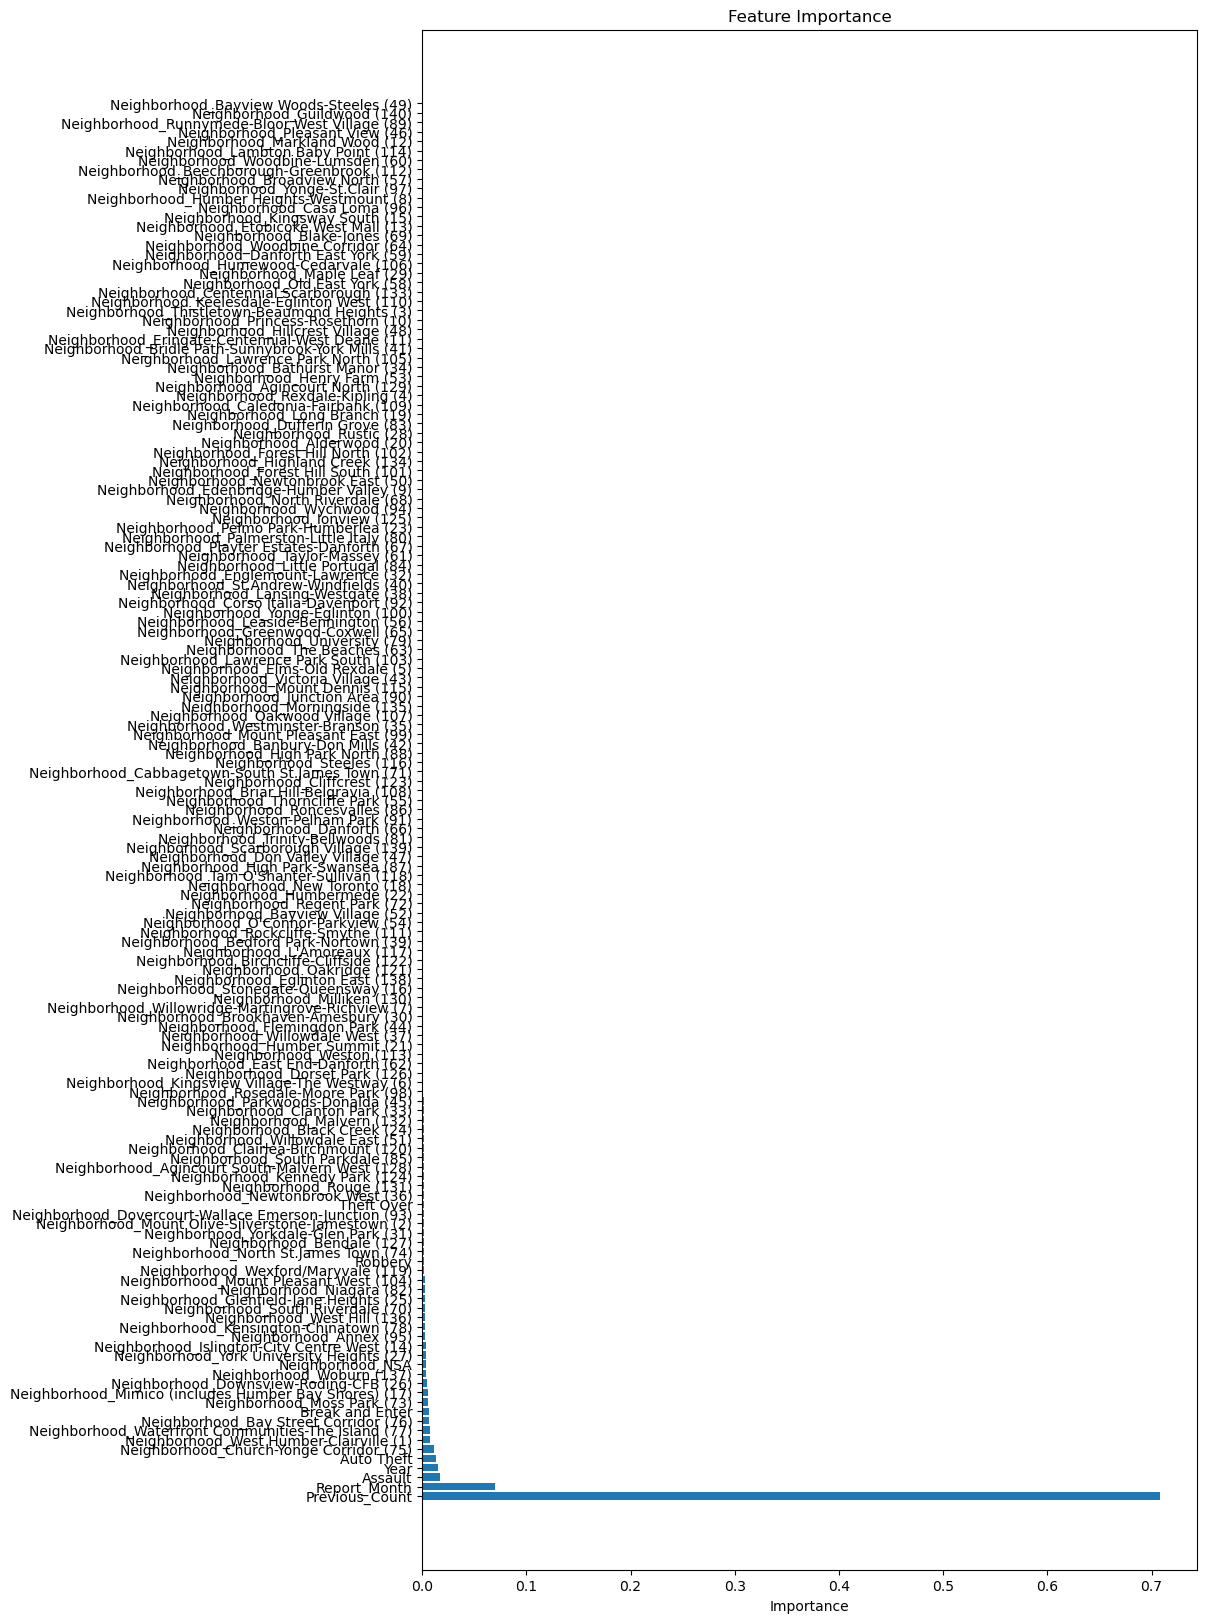

In [27]:
import matplotlib.pyplot as plt
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()